In [1]:
import pandas as pd
import numpy as np
import matplotlib
import scikitplot as skplt
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import shap
import graphviz
import xgboost as xgb
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
df = pd.read_csv('best_actor_hd.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8340 entries, 0 to 8339
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   actor                      8340 non-null   object 
 1   role                       8340 non-null   object 
 2   title                      8340 non-null   object 
 3   award                      8340 non-null   float64
 4   score_1                    8340 non-null   float64
 5   score_2                    8340 non-null   float64
 6   num_reviews                8340 non-null   float64
 7   polarity_mean              8340 non-null   float64
 8   objectivity_mean           8340 non-null   float64
 9   numeric_key                8340 non-null   int64  
 10  ordering                   8340 non-null   int64  
 11  height                     8340 non-null   float64
 12  year                       8340 non-null   int64  
 13  duration                   8340 non-null   int64

In [4]:
df.describe()

award      score_1      score_2  num_reviews  polarity_mean  \
count  8340.000000  8340.000000  8340.000000  8340.000000    8340.000000   
mean      0.063909    40.599640    40.608873     9.725659       0.085345   
std       0.285757    34.446202    37.447243    14.160255       0.159247   
min       0.000000     0.000000     0.000000     0.000000      -1.000000   
25%       0.000000     0.000000     0.000000     0.000000       0.000000   
50%       0.000000    46.000000    39.000000     2.000000       0.000000   
75%       0.000000    73.000000    78.000000    14.000000       0.171954   
max       2.000000    99.000000   100.000000    66.000000       1.000000   

       objectivity_mean  numeric_key     ordering       height         year  \
count       8340.000000  8340.000000  8340.000000  8340.000000  8340.000000   
mean           0.333301   116.752878     1.812110   180.458513  1977.037290   
std            0.287861    66.502140     1.037871     6.953434    27.368352   
min            0.000000     0.000000     1.000000   157.000000  1917.000000   
25%            0.000000    63.000000     1.000000   175.000000  1953.000000   
50%            0.466580   115.000000     1.000000   180.000000  1979.000000   
75%            0.572105   173.000000     2.000000   186.000000  2002.000000   
max            1.000000   232.000000    10.000000   196.000000  2020.000000   

       ...  females_30age_votes  females_45age_avg_vote  females_45age_votes  \
count  ...          8340.000000             8340.000000          8340.000000   
mean   ...          3743.876978                6.668441          1083.594365   
std    ...         10187.660959                0.932727          2291.409534   
min    ...             0.000000                0.000000             0.000000   
25%    ...            31.000000                6.200000            50.000000   
50%    ...           201.000000                6.800000           213.000000   
75%    ...          2242.250000                7.300000          1076.000000   
max    ...        129249.000000               10.000000         34317.000000   

       top1000_voters_rating  top1000_voters_votes  us_voters_rating  \
count            8340.000000            8340.00000       8340.000000   
mean                6.099940             259.46223          6.553381   
std                 0.857846             215.54052          0.907233   
min                 1.900000               3.00000          1.500000   
25%                 5.600000              83.00000          6.100000   
50%                 6.100000             189.00000          6.600000   
75%                 6.600000             387.00000          7.100000   
max                 9.100000             928.00000          9.300000   

       us_voters_votes  non_us_voters_rating  non_us_voters_votes  \
count      8340.000000           8340.000000          8340.000000   
mean       9724.732494              6.392758         25678.468225   
std       24100.386069              0.895061         67603.998745   
min           6.000000              1.000000             6.000000   
25%         273.000000              5.900000           267.750000   
50%        1187.500000              6.400000          1699.000000   
75%        7364.000000              7.000000         15904.000000   
max      348363.000000              9.500000        887226.000000   

       age_at_performance  
count         8340.000000  
mean            46.415588  
std             13.341051  
min              9.000000  
25%             36.000000  
50%             45.000000  
75%             56.000000  
max             95.000000  

[8 rows x 65 columns]

(65.0, 0.0)

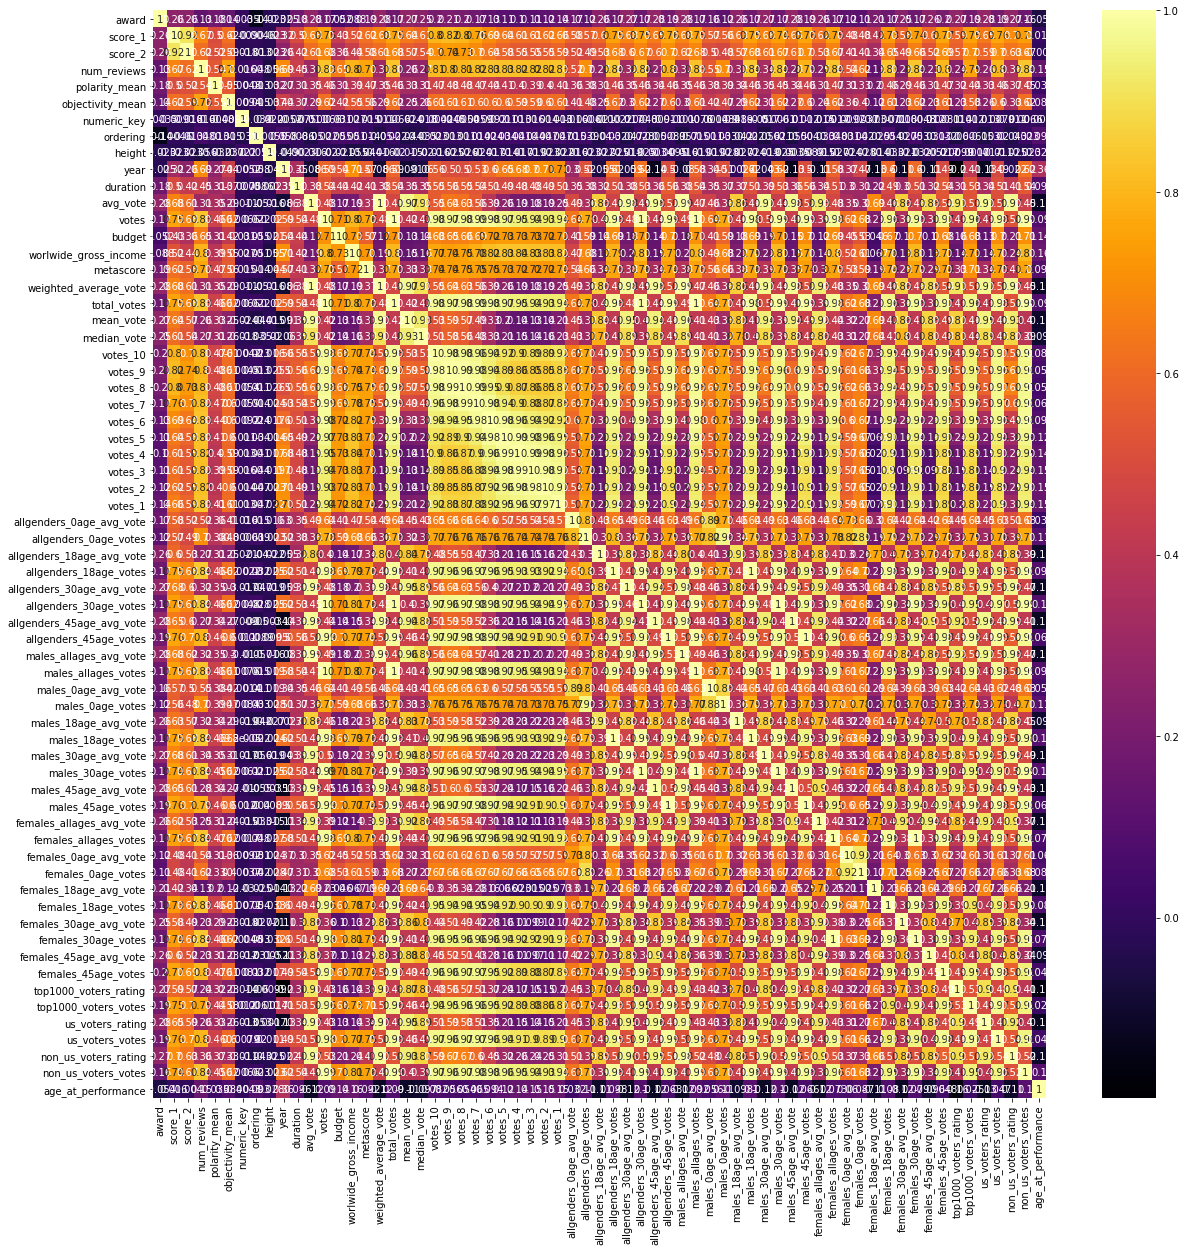

In [5]:
plt.figure(figsize=(20,20))
c = df.corr(method='spearman')
ax = sns.heatmap(c,cmap='inferno',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

The correlation heatmap indicates that there are clear patterns apparent with much of the data added from the Kaggle datasets. There are stronger correlation scores between the older data pertaining to critic/audience scores and the new information. 

In [90]:
def balancedWeights(label_set):
    classes = np.unique(label_set)
    class_weights = class_weight.compute_class_weight('balanced',
                                                           classes,
                                                           label_set)
    
    cw_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
    cw_array = [cw_dict[i] for i in label_set.values]
    return cw_array

In [8]:
X = df[['score_1','score_2','metascore','avg_vote','weighted_average_vote','mean_vote','median_vote',
        'males_allages_avg_vote','males_allages_votes','females_allages_avg_vote','females_allages_votes',
       'top1000_voters_rating','top1000_voters_votes','us_voters_rating','us_voters_votes','non_us_voters_rating',
       'non_us_voters_votes','age_at_performance','year','height','ordering','num_reviews','polarity_mean','objectivity_mean',
       'budget','worlwide_gross_income','duration','numeric_key']]
y = df['award']

In [10]:
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.1, random_state=625)
train_target_weights = balancedWeights(train_targets)


The dataset is split into the target's and features for training the models.

In [11]:
param_search1 = {
    'min_child_weight': [2,4,8,10,12],
    'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1.0],
    'subsample' : [0.5,0.6,0.7,0.8,0.9],
    'max_depth': [3,4,5,6,7,8,9,10],
}

base_clf = xgb.XGBClassifier(learning_rate=0.1,n_estimators=1000, objective='multi:softprob', num_class=3)
random_search1 = RandomizedSearchCV(base_clf, param_search1,
                             scoring='roc_auc_ovo', n_jobs=5,
                             cv=5)
random_search1.fit(train_features, train_targets, sample_weight=train_target_weights)

print('\n All results:')
print(random_search1.cv_results_)
print('\n Best estimator:')
print(random_search1.best_estimator_)
print('\n Best hyperparameters:')
print(random_search1.best_params_)


 All results:
{'mean_fit_time': array([44.89006619, 48.51610074, 35.71417775, 53.17173052, 51.95632224,
       46.81461926, 58.10782123, 34.67421889, 46.77251401, 48.08808117]), 'std_fit_time': array([1.21288821, 0.89789579, 0.82414723, 0.59008195, 0.59122496,
       1.00868691, 1.73339564, 0.9446823 , 2.39991982, 2.1865613 ]), 'mean_score_time': array([0.57534552, 0.51833253, 0.64459634, 0.60177159, 0.64790578,
       0.47548628, 0.61038456, 0.50534635, 0.47581253, 0.29726934]), 'std_score_time': array([0.1535523 , 0.09522339, 0.09477426, 0.08438003, 0.08175263,
       0.10964287, 0.10499578, 0.07482171, 0.06362336, 0.05565616]), 'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.6, 0.8, 0.8, 0.9, 0.8, 0.6, 0.6],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[4, 4, 8, 4, 2, 10, 2, 8, 8, 10],
             mask=[False, False, F

An initial random cross validation search provides a "best" neighborhood of hyperparameters from which finer tunning can begin.

In [13]:
model_1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=10,monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_1.fit(train_features, train_targets, eval_set=[(train_features, train_targets),(test_features, test_targets)], sample_weight = train_target_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.20037	validation_1-merror:0.20983
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.15361	validation_1-merror:0.17986
[2]	validation_0-merror:0.13842	validation_1-merror:0.17026
[3]	validation_0-merror:0.13349	validation_1-merror:0.16547
[4]	validation_0-merror:0.12910	validation_1-merror:0.16547
[5]	validation_0-merror:0.12883	validation_1-merror:0.15588
[6]	validation_0-merror:0.13109	validation_1-merror:0.15468
[7]	validation_0-merror:0.12843	validation_1-merror:0.15827
[8]	validation_0-merror:0.12696	validation_1-merror:0.16547
[9]	validation_0-merror:0.12270	validation_1-merror:0.15827
[10]	validation_0-merror:0.11964	validation_1-merror:0.15707
[11]	validation_0-merror:0.11644	validation_1-merror:0.15228
[12]	validation_0-merror:0.11524	validation_1-merror:0.15348
[13]	validation_0-merror:0.11457	validation_1-merror:0

[132]	validation_0-merror:0.02611	validation_1-merror:0.07914
[133]	validation_0-merror:0.02598	validation_1-merror:0.07794
[134]	validation_0-merror:0.02571	validation_1-merror:0.07674
[135]	validation_0-merror:0.02558	validation_1-merror:0.07794
[136]	validation_0-merror:0.02491	validation_1-merror:0.07674
[137]	validation_0-merror:0.02478	validation_1-merror:0.07554
[138]	validation_0-merror:0.02438	validation_1-merror:0.07434
[139]	validation_0-merror:0.02425	validation_1-merror:0.07314
[140]	validation_0-merror:0.02411	validation_1-merror:0.07194
[141]	validation_0-merror:0.02358	validation_1-merror:0.07314
[142]	validation_0-merror:0.02331	validation_1-merror:0.07194
[143]	validation_0-merror:0.02371	validation_1-merror:0.07194
[144]	validation_0-merror:0.02345	validation_1-merror:0.07194
[145]	validation_0-merror:0.02252	validation_1-merror:0.07434
[146]	validation_0-merror:0.02225	validation_1-merror:0.07554
[147]	validation_0-merror:0.02198	validation_1-merror:0.07434
[148]	va

[265]	validation_0-merror:0.00773	validation_1-merror:0.06115
[266]	validation_0-merror:0.00746	validation_1-merror:0.06115
[267]	validation_0-merror:0.00759	validation_1-merror:0.06115
[268]	validation_0-merror:0.00746	validation_1-merror:0.06115
Stopping. Best iteration:
[218]	validation_0-merror:0.01079	validation_1-merror:0.05875



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
m1_train_preds = model_1.predict(train_features)
m1_train_proba = model_1.predict_proba(train_features)
m1_test_preds = model_1.predict(test_features)
m1_test_proba = model_1.predict_proba(test_features)
print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(train_targets,m1_train_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(train_targets, m1_train_proba, average='weighted',multi_class='ovo')))
print( "Accuracy (Test): {:.2%}".format(metrics.balanced_accuracy_score(test_targets, m1_test_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(test_targets, m1_test_proba, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 99.62%
AUC Score (Train): 1.0
Accuracy (Test): 57.35%
AUC Score (Train): 0.9227


Presidence is given to the ROC AUC score before the accuracy. The intent is gauge the confidence of the model on the predictions it is making. Once the neighborhood for the high impact hyperparameters is determined, they are checked to verify that they are the correct values.

In [15]:
model_1.set_params(n_estimators=219)
param_search2 = {
    'min_child_weight': [9,10,11],
    'max_depth': [6,7,8],
    'subsample': [0.7,0.8,0.9],
    'colsample_bytree': [0.7,0.8,0.9]
    }
grid_search2 = GridSearchCV(model_1, param_search2,
                            scoring='roc_auc_ovo',
                            n_jobs=5, cv=5)
grid_search2.fit(train_features, train_targets, sample_weight=train_target_weights)

print('\n All results:')
print(grid_search2.cv_results_)
print('\n Best estimator:')
print(grid_search2.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search2.best_params_)


 All results:
{'mean_fit_time': array([12.23552032, 11.92475576, 11.69349914, 11.96282191, 12.00385118,
       11.83612671, 11.76718946, 11.5631547 , 11.53961616, 12.79561467,
       13.00476036, 12.88657804, 12.50621991, 12.83465819, 12.66462064,
       12.70169063, 12.63639526, 12.82112703, 13.24757652, 13.77174444,
       13.78447375, 13.30453706, 13.69824491, 13.65433922, 13.0722827 ,
       13.69677978, 13.65662675, 12.93095822, 13.16498404, 13.1630054 ,
       13.03677564, 12.74340992, 12.99082417, 13.07783341, 12.95447984,
       13.04191132, 14.1871974 , 14.5686748 , 14.2500021 , 14.31824484,
       13.96910896, 14.32823749, 14.07802119, 14.32016673, 14.31442118,
       15.00547428, 15.38077765, 15.2561852 , 14.99207001, 14.88803444,
       15.43972459, 14.7929975 , 14.99825678, 15.04648252, 14.56609359,
       14.59766741, 14.24210711, 14.52246852, 14.28106632, 14.36023149,
       13.9782784 , 14.62051501, 14.33443084, 15.9437562 , 15.98836994,
       15.88766403, 15.13603487

In [17]:
model_2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, monotone_constraints='()',
              n_estimators=219, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_2.fit(train_features, train_targets, eval_set=[(train_features, train_targets),(test_features, test_targets)], sample_weight = train_target_weights, early_stopping_rounds = 21)

[0]	validation_0-merror:0.22755	validation_1-merror:0.25060
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 21 rounds.
[1]	validation_0-merror:0.19837	validation_1-merror:0.21703
[2]	validation_0-merror:0.18425	validation_1-merror:0.19425
[3]	validation_0-merror:0.17239	validation_1-merror:0.19904
[4]	validation_0-merror:0.16480	validation_1-merror:0.19544
[5]	validation_0-merror:0.16147	validation_1-merror:0.19065
[6]	validation_0-merror:0.16467	validation_1-merror:0.18825
[7]	validation_0-merror:0.16707	validation_1-merror:0.18825
[8]	validation_0-merror:0.15747	validation_1-merror:0.18105
[9]	validation_0-merror:0.15015	validation_1-merror:0.17626
[10]	validation_0-merror:0.14828	validation_1-merror:0.17626
[11]	validation_0-merror:0.14628	validation_1-merror:0.17746
[12]	validation_0-merror:0.14362	validation_1-merror:0.17386
[13]	validation_0-merror:0.14322	validation_1-merror:0

[132]	validation_0-merror:0.03917	validation_1-merror:0.08034
[133]	validation_0-merror:0.03850	validation_1-merror:0.08153
[134]	validation_0-merror:0.03784	validation_1-merror:0.08273
[135]	validation_0-merror:0.03824	validation_1-merror:0.08034
[136]	validation_0-merror:0.03784	validation_1-merror:0.07914
[137]	validation_0-merror:0.03757	validation_1-merror:0.07794
[138]	validation_0-merror:0.03664	validation_1-merror:0.08034
[139]	validation_0-merror:0.03637	validation_1-merror:0.08034
[140]	validation_0-merror:0.03650	validation_1-merror:0.08273
[141]	validation_0-merror:0.03597	validation_1-merror:0.08153
[142]	validation_0-merror:0.03610	validation_1-merror:0.08153
[143]	validation_0-merror:0.03571	validation_1-merror:0.07914
[144]	validation_0-merror:0.03490	validation_1-merror:0.08034
[145]	validation_0-merror:0.03490	validation_1-merror:0.08153
[146]	validation_0-merror:0.03464	validation_1-merror:0.08034
[147]	validation_0-merror:0.03424	validation_1-merror:0.07914
[148]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=219, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
m2_train_preds = model_2.predict(train_features)
m2_train_proba = model_2.predict_proba(train_features)
m2_test_preds = model_2.predict(test_features)
m2_test_proba = model_2.predict_proba(test_features)
print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(train_targets,m2_train_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(train_targets, m2_train_proba, average='weighted',multi_class='ovo')))
print( "Accuracy (Test): {:.2%}".format(metrics.balanced_accuracy_score(test_targets, m2_test_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(test_targets, m2_test_proba, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 99.18%
AUC Score (Train): 0.9999
Accuracy (Test): 58.92%
AUC Score (Train): 0.9247


In [19]:
model_2.set_params(n_estimators=219)
param_search3 = {
    'gamma': [i/10 for i in range(0,6)]
}

grid_search3 = GridSearchCV(model_2, param_search3,
                            scoring='roc_auc_ovo',
                            n_jobs=5, cv=5)
grid_search3.fit(train_features, train_targets, sample_weight=train_target_weights)

print('\n All results:')
print(grid_search3.cv_results_)
print('\n Best estimator:')
print(grid_search3.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search3.best_params_)


 All results:
{'mean_fit_time': array([11.61606455, 11.6074379 , 11.72289901, 11.78744073, 11.77200813,
       10.92844191]), 'std_fit_time': array([0.2045779 , 0.38998017, 0.53701008, 0.55330887, 0.28609729,
       0.24931517]), 'mean_score_time': array([0.11768451, 0.13841586, 0.13344979, 0.13779736, 0.11974635,
       0.09724817]), 'std_score_time': array([0.012602  , 0.03675649, 0.03608754, 0.0235712 , 0.01399736,
       0.02385751]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}], 'split0_test_score': array([0.82961881, 0.82680773, 0.82132745, 0.83119656, 0.8369067 ,
       0.82855787]), 'split1_test_score': array([0.79948422, 0.80088069, 0.80278471, 0.80249053, 0.79326871,
       0.80145219]), 'split2_test_score': array([0.81012344, 0.81233082, 0

In [22]:
model_3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, monotone_constraints='()',
              n_estimators=219, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_3.fit(train_features, train_targets, eval_set=[(train_features, train_targets),(test_features, test_targets)], sample_weight = train_target_weights, early_stopping_rounds = 10)

[0]	validation_0-merror:0.22755	validation_1-merror:0.25060
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.19837	validation_1-merror:0.21703
[2]	validation_0-merror:0.18425	validation_1-merror:0.19425
[3]	validation_0-merror:0.17239	validation_1-merror:0.19904
[4]	validation_0-merror:0.16480	validation_1-merror:0.19544
[5]	validation_0-merror:0.16147	validation_1-merror:0.19065
[6]	validation_0-merror:0.16493	validation_1-merror:0.18825
[7]	validation_0-merror:0.16720	validation_1-merror:0.18825
[8]	validation_0-merror:0.15801	validation_1-merror:0.18105
[9]	validation_0-merror:0.15055	validation_1-merror:0.17746
[10]	validation_0-merror:0.14988	validation_1-merror:0.17746
[11]	validation_0-merror:0.14562	validation_1-merror:0.17746
[12]	validation_0-merror:0.14402	validation_1-merror:0.17626
[13]	validation_0-merror:0.14349	validation_1-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=219, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
m3_train_preds = model_3.predict(train_features)
m3_train_proba = model_3.predict_proba(train_features)
m3_test_preds = model_3.predict(test_features)
m3_test_proba = model_3.predict_proba(test_features)
print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(train_targets,m3_train_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(train_targets, m3_train_proba, average='weighted',multi_class='ovo')))
print( "Accuracy (Test): {:.2%}".format(metrics.balanced_accuracy_score(test_targets, m3_test_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(test_targets, m3_test_proba, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 98.15%
AUC Score (Train): 0.9987
Accuracy (Test): 65.12%
AUC Score (Train): 0.9225


In [24]:
model_3.set_params(n_estimators=113)
param_search4 = {
    'reg_alpha': [1e-5,1e-2,0.1,1,10,100],
    'reg_lambda': [1e-5,1e-2,0.1,1,10,100]
}
grid_search4 = GridSearchCV(model_3, param_search4,
                            scoring='roc_auc_ovo',
                            n_jobs=5, cv=5)
grid_search4.fit(train_features, train_targets, sample_weight=train_target_weights)

print('\n All results:')
print(grid_search4.cv_results_)
print('\n Best estimator:')
print(grid_search4.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search4.best_params_)


 All results:
{'mean_fit_time': array([7.16515064, 6.30211954, 6.37528405, 6.36803198, 6.42044654,
       6.5258235 , 6.34004669, 6.27626548, 6.32136312, 6.30182977,
       6.57718463, 6.56689739, 6.31899333, 6.30053325, 6.24634681,
       6.20492711, 6.33536296, 6.51127367, 6.3567235 , 6.34090638,
       6.40918336, 6.34596667, 6.37306814, 6.60065703, 6.49062729,
       6.51385841, 6.57501378, 6.45769172, 6.51397557, 6.71745954,
       4.25226774, 4.62539892, 4.29586248, 4.51044784, 4.55453634,
       3.85426397]), 'std_fit_time': array([0.44166881, 0.40662081, 0.48051862, 0.32310479, 0.49320107,
       0.40668294, 0.60009795, 0.37112269, 0.28266631, 0.19956747,
       0.16897121, 0.20053234, 0.34963388, 0.13062368, 0.13514596,
       0.27753504, 0.20621911, 0.24857001, 0.20759402, 0.08800174,
       0.12878462, 0.18238015, 0.32749749, 0.23461836, 0.29181502,
       0.16960244, 0.30205923, 0.18463258, 0.27628389, 0.17800598,
       0.24532141, 0.17165046, 0.2038447 , 0.23663274, 0.18

In [25]:
param_search45 = {
    'reg_alpha': [0.05,0.1,0.15],
    'reg_lambda': [0.005,0.01,0.015]
}
grid_search45 = GridSearchCV(model_3, param_search45,
                            scoring='roc_auc_ovo',
                            n_jobs=5, cv=5)
grid_search45.fit(train_features, train_targets, sample_weight=train_target_weights)

print('\n All results:')
print(grid_search45.cv_results_)
print('\n Best estimator:')
print(grid_search45.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search45.best_params_)


 All results:
{'mean_fit_time': array([7.15047584, 7.28738446, 7.45629449, 7.3756525 , 6.30511079,
       6.24576025, 6.29488926, 6.30926676, 6.50457282]), 'std_fit_time': array([0.24979841, 0.48228129, 0.30185073, 0.16721735, 0.16056794,
       0.4349898 , 0.40350477, 0.2176319 , 0.35050058]), 'mean_score_time': array([0.1054141 , 0.08758006, 0.0675631 , 0.0764544 , 0.06417127,
       0.07015157, 0.07747817, 0.06243272, 0.05449309]), 'std_score_time': array([0.02466667, 0.02272763, 0.005895  , 0.00976511, 0.00490892,
       0.01939116, 0.01282879, 0.00478831, 0.00849122]), 'param_reg_alpha': masked_array(data=[0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_reg_lambda': masked_array(data=[0.005, 0.01, 0.015, 0.005, 0.01, 0.015, 0.005, 0.01,
                   0.015],
             mask=[False, False, False, False, False, Fal

In [30]:
model_4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, monotone_constraints='()',
              n_estimators=113, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_4.fit(train_features, train_targets, eval_set=[(train_features, train_targets),(test_features, test_targets)], sample_weight = train_target_weights, early_stopping_rounds = 10)

[0]	validation_0-merror:0.22982	validation_1-merror:0.25420
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.20117	validation_1-merror:0.22302
[2]	validation_0-merror:0.18305	validation_1-merror:0.20624
[3]	validation_0-merror:0.16986	validation_1-merror:0.18825
[4]	validation_0-merror:0.15894	validation_1-merror:0.18825
[5]	validation_0-merror:0.15801	validation_1-merror:0.18345
[6]	validation_0-merror:0.16134	validation_1-merror:0.18345
[7]	validation_0-merror:0.16094	validation_1-merror:0.18345
[8]	validation_0-merror:0.15521	validation_1-merror:0.18945
[9]	validation_0-merror:0.15001	validation_1-merror:0.18465
[10]	validation_0-merror:0.14682	validation_1-merror:0.18225
[11]	validation_0-merror:0.14588	validation_1-merror:0.17866
[12]	validation_0-merror:0.14175	validation_1-merror:0.17386
[13]	validation_0-merror:0.14162	validation_1-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=113, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
m4_train_preds = model_4.predict(train_features)
m4_train_proba = model_4.predict_proba(train_features)
m4_test_preds = model_4.predict(test_features)
m4_test_proba = model_4.predict_proba(test_features)
print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(train_targets,m4_train_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(train_targets, m4_train_proba, average='weighted',multi_class='ovo')))
print( "Accuracy (Test): {:.2%}".format(metrics.balanced_accuracy_score(test_targets, m4_test_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(test_targets, m4_test_proba, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 95.83%
AUC Score (Train): 0.99
Accuracy (Test): 66.08%
AUC Score (Train): 0.917


The major hyperparameters including regularization parameters have been determined. This has resulted in an increase in accruacy and a maintained ROC AUC score for both the training and testing sets.

A final "general" model will be trained using this this original random sample as well as reducing the learning rate of the model.

In [63]:
general_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=11, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
general_model.fit(train_features, train_targets, eval_set=[(train_features, train_targets),(test_features, test_targets)], sample_weight = train_target_weights, early_stopping_rounds = 100)

[0]	validation_0-merror:0.25060	validation_1-merror:0.27218
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.23101	validation_1-merror:0.24460
[2]	validation_0-merror:0.23395	validation_1-merror:0.26259
[3]	validation_0-merror:0.22355	validation_1-merror:0.24700
[4]	validation_0-merror:0.22702	validation_1-merror:0.25180
[5]	validation_0-merror:0.22542	validation_1-merror:0.24820
[6]	validation_0-merror:0.23062	validation_1-merror:0.24580
[7]	validation_0-merror:0.23421	validation_1-merror:0.25420
[8]	validation_0-merror:0.23181	validation_1-merror:0.24940
[9]	validation_0-merror:0.22635	validation_1-merror:0.24700
[10]	validation_0-merror:0.22728	validation_1-merror:0.23981
[11]	validation_0-merror:0.22715	validation_1-merror:0.24580
[12]	validation_0-merror:0.22329	validation_1-merror:0.23741
[13]	validation_0-merror:0.22315	validation_1-merror:

[132]	validation_0-merror:0.16560	validation_1-merror:0.18345
[133]	validation_0-merror:0.16533	validation_1-merror:0.18465
[134]	validation_0-merror:0.16480	validation_1-merror:0.18465
[135]	validation_0-merror:0.16493	validation_1-merror:0.18345
[136]	validation_0-merror:0.16480	validation_1-merror:0.18345
[137]	validation_0-merror:0.16414	validation_1-merror:0.18465
[138]	validation_0-merror:0.16427	validation_1-merror:0.18465
[139]	validation_0-merror:0.16360	validation_1-merror:0.18465
[140]	validation_0-merror:0.16360	validation_1-merror:0.18465
[141]	validation_0-merror:0.16360	validation_1-merror:0.18345
[142]	validation_0-merror:0.16320	validation_1-merror:0.18585
[143]	validation_0-merror:0.16294	validation_1-merror:0.18585
[144]	validation_0-merror:0.16200	validation_1-merror:0.18465
[145]	validation_0-merror:0.16147	validation_1-merror:0.18465
[146]	validation_0-merror:0.16120	validation_1-merror:0.18465
[147]	validation_0-merror:0.16027	validation_1-merror:0.18345
[148]	va

[265]	validation_0-merror:0.13909	validation_1-merror:0.15947
[266]	validation_0-merror:0.13882	validation_1-merror:0.15827
[267]	validation_0-merror:0.13842	validation_1-merror:0.15827
[268]	validation_0-merror:0.13776	validation_1-merror:0.15827
[269]	validation_0-merror:0.13736	validation_1-merror:0.15707
[270]	validation_0-merror:0.13709	validation_1-merror:0.15707
[271]	validation_0-merror:0.13696	validation_1-merror:0.15707
[272]	validation_0-merror:0.13696	validation_1-merror:0.15707
[273]	validation_0-merror:0.13642	validation_1-merror:0.15707
[274]	validation_0-merror:0.13682	validation_1-merror:0.15707
[275]	validation_0-merror:0.13656	validation_1-merror:0.15707
[276]	validation_0-merror:0.13642	validation_1-merror:0.15707
[277]	validation_0-merror:0.13642	validation_1-merror:0.15707
[278]	validation_0-merror:0.13629	validation_1-merror:0.15707
[279]	validation_0-merror:0.13616	validation_1-merror:0.15707
[280]	validation_0-merror:0.13603	validation_1-merror:0.15707
[281]	va

[398]	validation_0-merror:0.11218	validation_1-merror:0.14029
[399]	validation_0-merror:0.11178	validation_1-merror:0.13909
[400]	validation_0-merror:0.11164	validation_1-merror:0.13909
[401]	validation_0-merror:0.11138	validation_1-merror:0.13909
[402]	validation_0-merror:0.11098	validation_1-merror:0.13909
[403]	validation_0-merror:0.11124	validation_1-merror:0.14029
[404]	validation_0-merror:0.11124	validation_1-merror:0.13909
[405]	validation_0-merror:0.11018	validation_1-merror:0.13669
[406]	validation_0-merror:0.11005	validation_1-merror:0.13789
[407]	validation_0-merror:0.11005	validation_1-merror:0.13789
[408]	validation_0-merror:0.11005	validation_1-merror:0.13789
[409]	validation_0-merror:0.11018	validation_1-merror:0.13789
[410]	validation_0-merror:0.11071	validation_1-merror:0.13789
[411]	validation_0-merror:0.11045	validation_1-merror:0.13909
[412]	validation_0-merror:0.11031	validation_1-merror:0.13909
[413]	validation_0-merror:0.10965	validation_1-merror:0.13909
[414]	va

[531]	validation_0-merror:0.09326	validation_1-merror:0.11151
[532]	validation_0-merror:0.09299	validation_1-merror:0.11151
[533]	validation_0-merror:0.09299	validation_1-merror:0.11151
[534]	validation_0-merror:0.09312	validation_1-merror:0.11151
[535]	validation_0-merror:0.09273	validation_1-merror:0.11151
[536]	validation_0-merror:0.09259	validation_1-merror:0.11271
[537]	validation_0-merror:0.09233	validation_1-merror:0.11271
[538]	validation_0-merror:0.09233	validation_1-merror:0.11151
[539]	validation_0-merror:0.09233	validation_1-merror:0.11151
[540]	validation_0-merror:0.09246	validation_1-merror:0.11151
[541]	validation_0-merror:0.09259	validation_1-merror:0.11271
[542]	validation_0-merror:0.09233	validation_1-merror:0.11271
[543]	validation_0-merror:0.09206	validation_1-merror:0.11271
[544]	validation_0-merror:0.09219	validation_1-merror:0.11271
[545]	validation_0-merror:0.09193	validation_1-merror:0.11271
[546]	validation_0-merror:0.09179	validation_1-merror:0.11271
[547]	va

[664]	validation_0-merror:0.07514	validation_1-merror:0.09712
[665]	validation_0-merror:0.07514	validation_1-merror:0.09712
[666]	validation_0-merror:0.07474	validation_1-merror:0.09712
[667]	validation_0-merror:0.07487	validation_1-merror:0.09712
[668]	validation_0-merror:0.07461	validation_1-merror:0.09712
[669]	validation_0-merror:0.07447	validation_1-merror:0.09712
[670]	validation_0-merror:0.07447	validation_1-merror:0.09592
[671]	validation_0-merror:0.07434	validation_1-merror:0.09592
[672]	validation_0-merror:0.07461	validation_1-merror:0.09592
[673]	validation_0-merror:0.07474	validation_1-merror:0.09592
[674]	validation_0-merror:0.07421	validation_1-merror:0.09592
[675]	validation_0-merror:0.07461	validation_1-merror:0.09592
[676]	validation_0-merror:0.07434	validation_1-merror:0.09592
[677]	validation_0-merror:0.07354	validation_1-merror:0.09592
[678]	validation_0-merror:0.07367	validation_1-merror:0.09472
[679]	validation_0-merror:0.07367	validation_1-merror:0.09472
[680]	va

[797]	validation_0-merror:0.06208	validation_1-merror:0.08873
[798]	validation_0-merror:0.06208	validation_1-merror:0.08873
[799]	validation_0-merror:0.06155	validation_1-merror:0.08873
[800]	validation_0-merror:0.06155	validation_1-merror:0.08993
[801]	validation_0-merror:0.06102	validation_1-merror:0.08873
[802]	validation_0-merror:0.06075	validation_1-merror:0.08993
[803]	validation_0-merror:0.06075	validation_1-merror:0.08873
[804]	validation_0-merror:0.06089	validation_1-merror:0.08873
[805]	validation_0-merror:0.06089	validation_1-merror:0.08873
[806]	validation_0-merror:0.06075	validation_1-merror:0.08873
[807]	validation_0-merror:0.06089	validation_1-merror:0.08993
[808]	validation_0-merror:0.06075	validation_1-merror:0.08993
[809]	validation_0-merror:0.06102	validation_1-merror:0.08993
[810]	validation_0-merror:0.06089	validation_1-merror:0.08873
[811]	validation_0-merror:0.06062	validation_1-merror:0.08873
[812]	validation_0-merror:0.06048	validation_1-merror:0.08993
[813]	va

[930]	validation_0-merror:0.05129	validation_1-merror:0.08513
[931]	validation_0-merror:0.05143	validation_1-merror:0.08513
[932]	validation_0-merror:0.05156	validation_1-merror:0.08513
[933]	validation_0-merror:0.05116	validation_1-merror:0.08513
[934]	validation_0-merror:0.05103	validation_1-merror:0.08513
[935]	validation_0-merror:0.05116	validation_1-merror:0.08513
[936]	validation_0-merror:0.05103	validation_1-merror:0.08513
[937]	validation_0-merror:0.05116	validation_1-merror:0.08513
[938]	validation_0-merror:0.05116	validation_1-merror:0.08513
[939]	validation_0-merror:0.05116	validation_1-merror:0.08513
[940]	validation_0-merror:0.05089	validation_1-merror:0.08513
[941]	validation_0-merror:0.05103	validation_1-merror:0.08513
[942]	validation_0-merror:0.05103	validation_1-merror:0.08513
[943]	validation_0-merror:0.05103	validation_1-merror:0.08513
[944]	validation_0-merror:0.05103	validation_1-merror:0.08513
[945]	validation_0-merror:0.05089	validation_1-merror:0.08513
[946]	va

[1062]	validation_0-merror:0.04423	validation_1-merror:0.08393
[1063]	validation_0-merror:0.04396	validation_1-merror:0.08393
[1064]	validation_0-merror:0.04410	validation_1-merror:0.08393
[1065]	validation_0-merror:0.04396	validation_1-merror:0.08393
[1066]	validation_0-merror:0.04396	validation_1-merror:0.08393
[1067]	validation_0-merror:0.04356	validation_1-merror:0.08393
[1068]	validation_0-merror:0.04396	validation_1-merror:0.08393
[1069]	validation_0-merror:0.04396	validation_1-merror:0.08393
[1070]	validation_0-merror:0.04383	validation_1-merror:0.08273
[1071]	validation_0-merror:0.04396	validation_1-merror:0.08273
[1072]	validation_0-merror:0.04396	validation_1-merror:0.08273
[1073]	validation_0-merror:0.04383	validation_1-merror:0.08273
[1074]	validation_0-merror:0.04370	validation_1-merror:0.08273
[1075]	validation_0-merror:0.04317	validation_1-merror:0.08273
[1076]	validation_0-merror:0.04343	validation_1-merror:0.08273
[1077]	validation_0-merror:0.04343	validation_1-merror:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
gm_train_preds = general_model.predict(train_features)
gm_train_proba = general_model.predict_proba(train_features)
gm_test_preds = general_model.predict(test_features)
gm_test_proba = general_model.predict_proba(test_features)
print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(train_targets,gm_train_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(train_targets, gm_train_proba, average='weighted',multi_class='ovo')))
print( "Accuracy (Test): {:.2%}".format(metrics.balanced_accuracy_score(test_targets, gm_test_preds)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(test_targets, gm_test_proba, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 98.39%
AUC Score (Train): 0.9987
Accuracy (Test): 59.96%
AUC Score (Train): 0.9285


Reducing the learning rate reduced the accuracy but provided an improvement in the ROC AUC score for both sets.

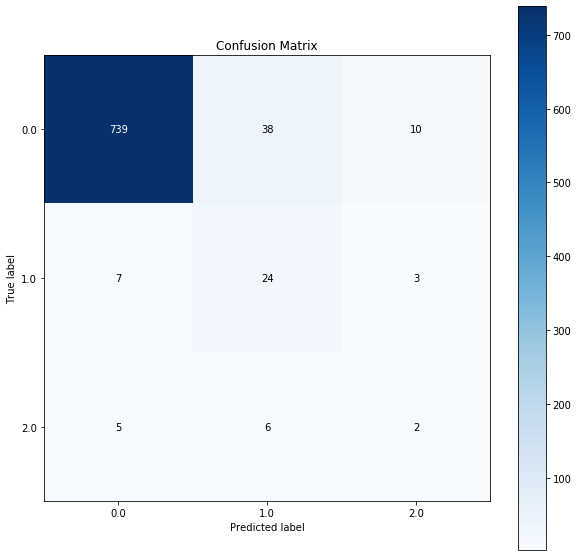

In [79]:
ax = skplt.metrics.plot_confusion_matrix(test_targets,gm_test_preds, figsize=(10,10))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.savefig('gm_conf_mat.png')
plt.show()

Based on the predictions for the test set we see that the model struggles the most on getting TP for the 2.0 class with only 2/11. Additionally, the model slightly over predicts the number of 2.0's, and overpredicts by ~29% the number of 1.0's. 

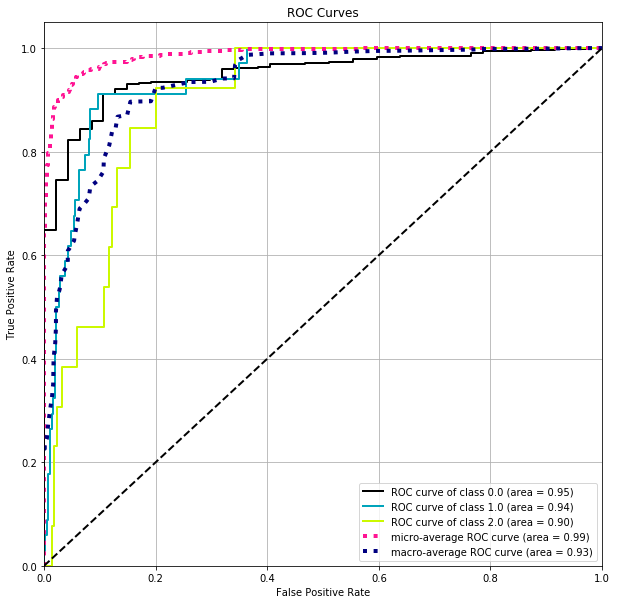

In [80]:
ax = skplt.metrics.plot_roc(test_targets, gm_test_proba, classes_to_plot=[0,1,2], figsize=(10,10))
plt.grid()
plt.savefig('gm_roc.png')
plt.show()

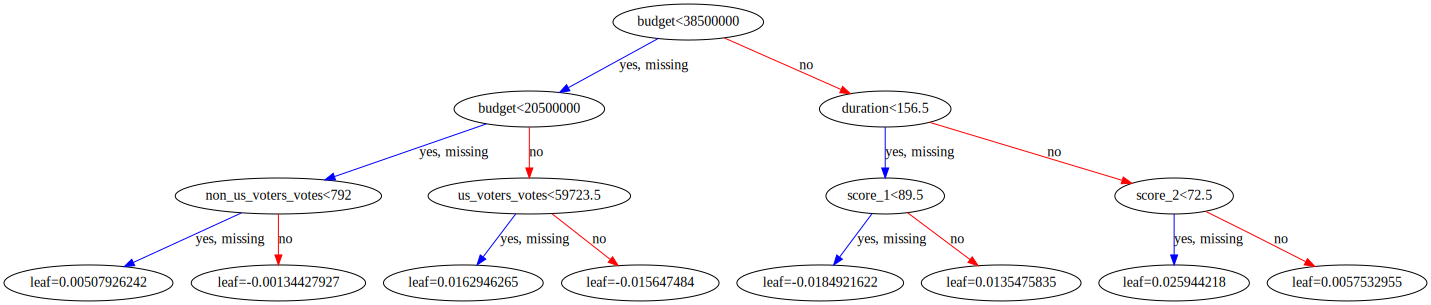

In [67]:
xgb.to_graphviz(general_model, num_trees=1027)

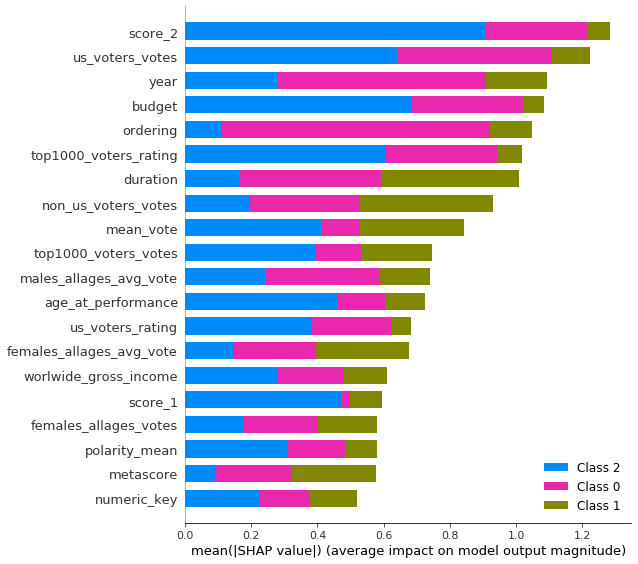

In [81]:
shap_explainer_general = shap.TreeExplainer(general_model)
shap_values_general = shap_explainer_general.shap_values(X)
shap.summary_plot(shap_values_general,X, show=False)
plt.savefig('gm_shap.png')
plt.show()

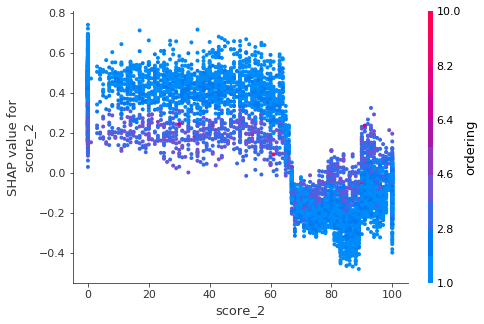

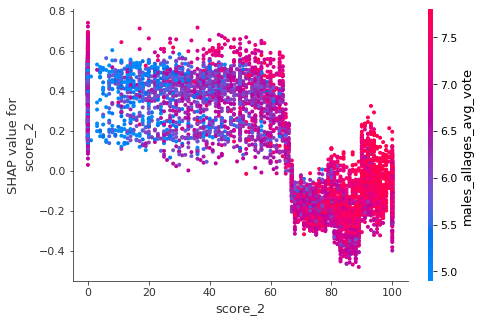

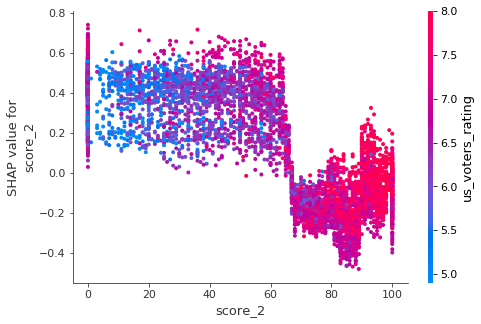

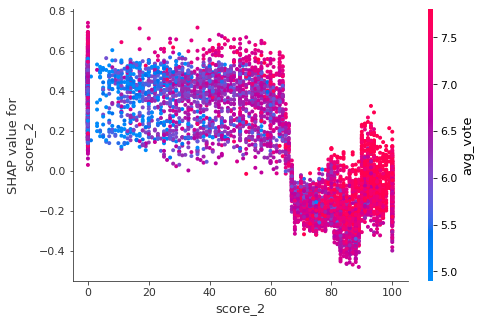

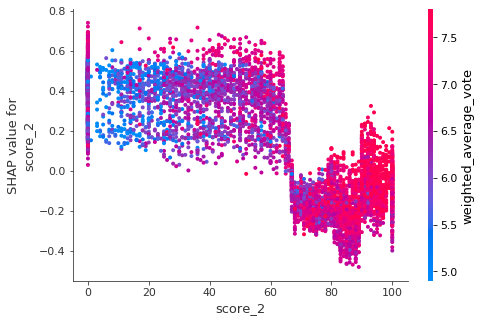

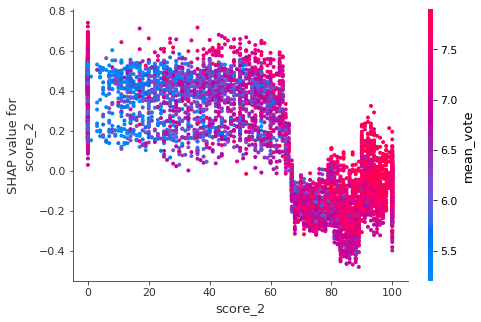

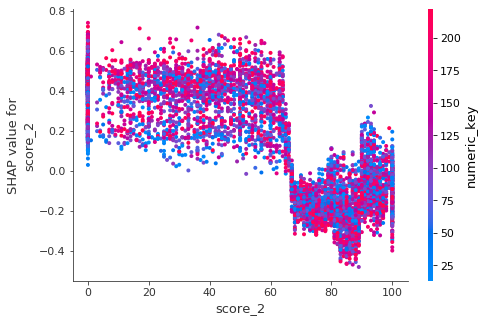

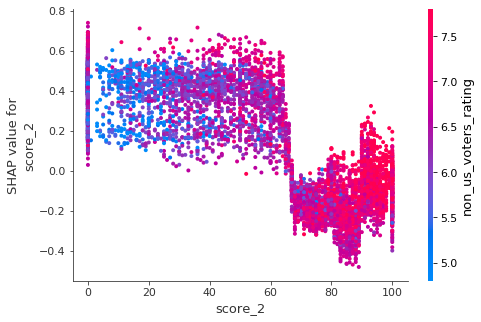

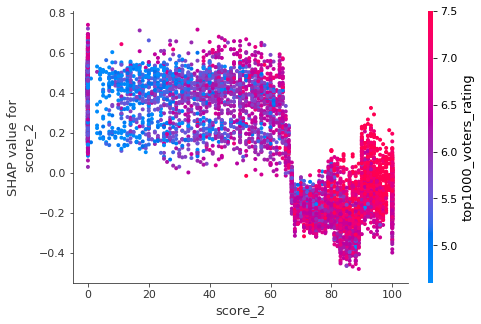

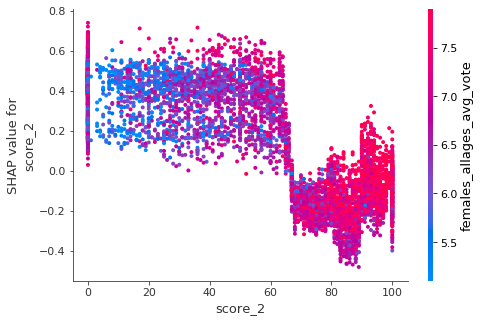

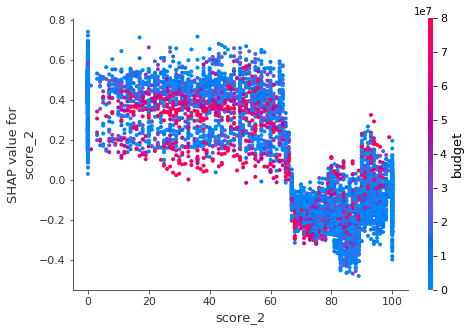

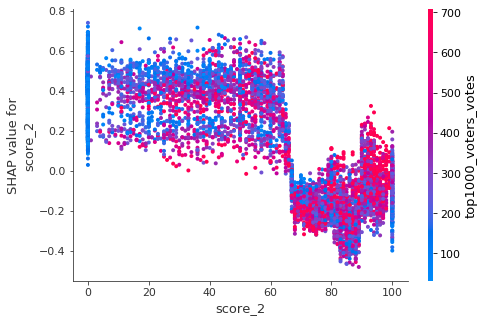

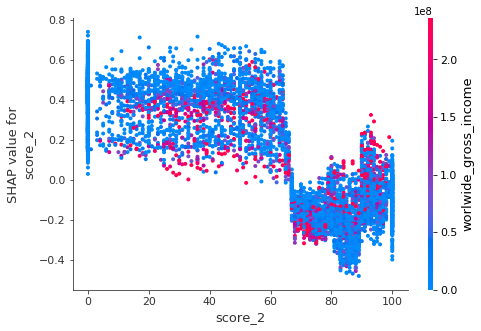

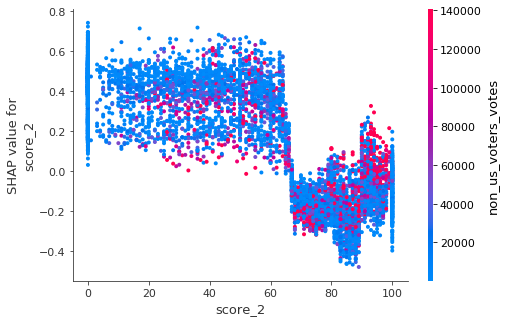

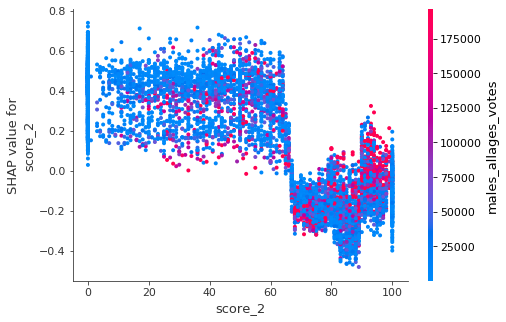

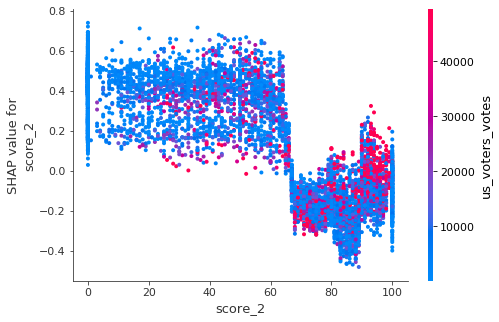

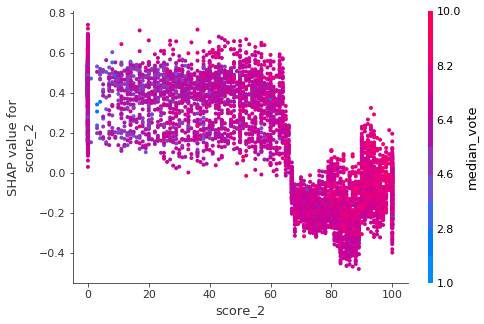

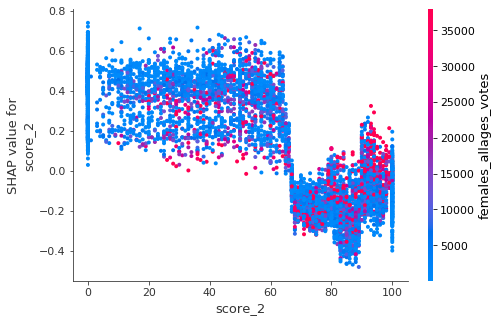

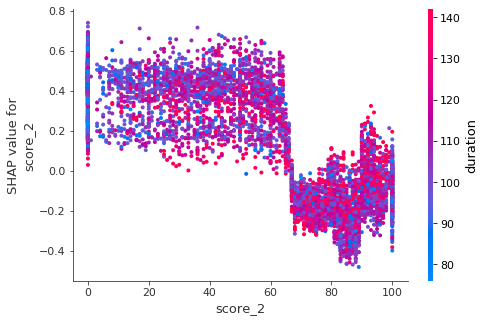

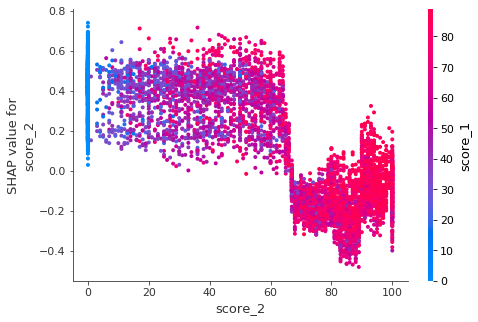

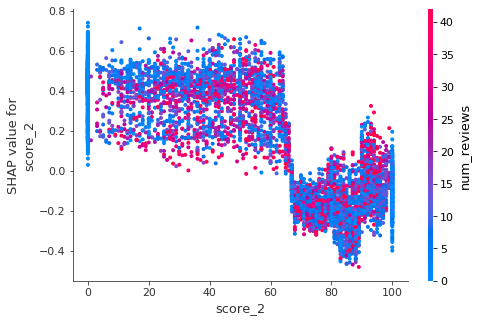

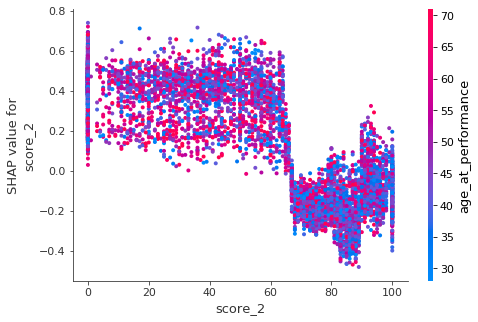

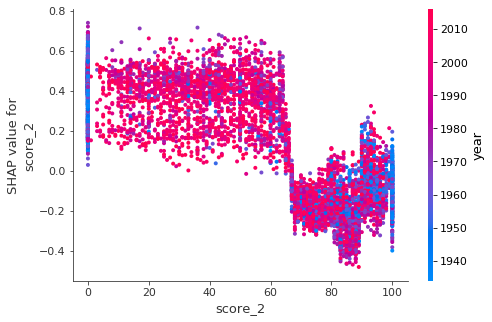

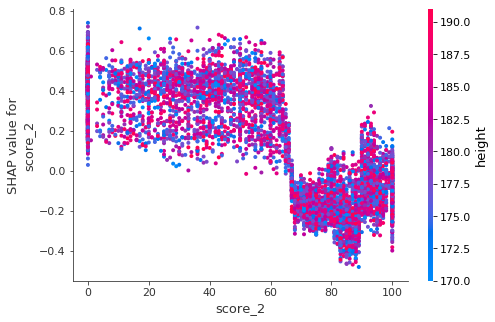

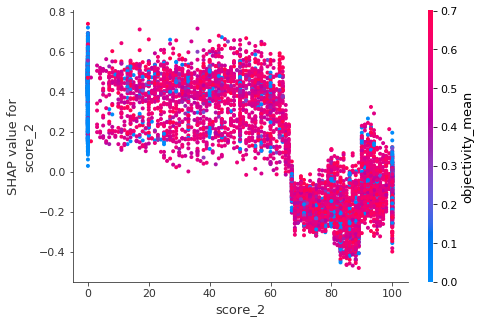

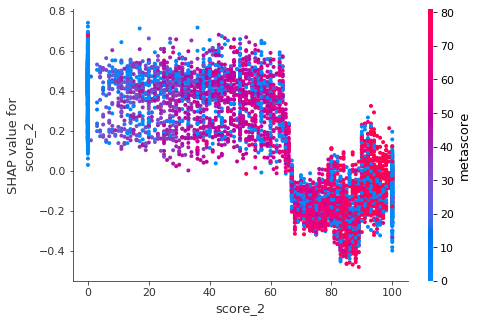

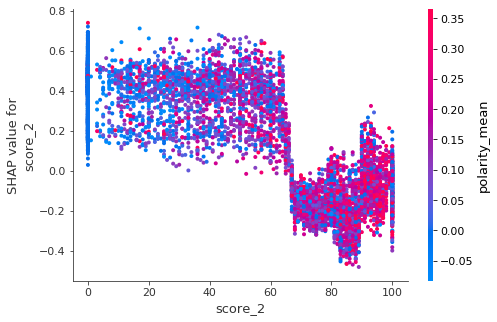

In [69]:
interactions = shap.approximate_interactions("score_2", shap_values_general[0],X)
for i in range(27):
    shap.dependence_plot("score_2",shap_values_general[0],X, interaction_index=interactions[i])

In [44]:
non_leo = df[df['actor'] != 'Leonardo DiCaprio']
leo_set = df[df['actor'] == 'Leonardo DiCaprio']

X_train_non, y_train_non = non_leo[['score_1','score_2','metascore','avg_vote','weighted_average_vote','mean_vote','median_vote',
        'males_allages_avg_vote','males_allages_votes','females_allages_avg_vote','females_allages_votes',
       'top1000_voters_rating','top1000_voters_votes','us_voters_rating','us_voters_votes','non_us_voters_rating',
       'non_us_voters_votes','age_at_performance','year','height','ordering','num_reviews','polarity_mean','objectivity_mean',
       'budget','worlwide_gross_income','duration','numeric_key']], non_leo['award']
X_test_leo, y_test_leo = leo_set[['score_1','score_2','metascore','avg_vote','weighted_average_vote','mean_vote','median_vote',
        'males_allages_avg_vote','males_allages_votes','females_allages_avg_vote','females_allages_votes',
       'top1000_voters_rating','top1000_voters_votes','us_voters_rating','us_voters_votes','non_us_voters_rating',
       'non_us_voters_votes','age_at_performance','year','height','ordering','num_reviews','polarity_mean','objectivity_mean',
       'budget','worlwide_gross_income','duration','numeric_key']], leo_set['award']

non_leo_wt = balancedWeights(y_train_non)

In [98]:
predictions_general = general_model.predict(X_test_leo)
probability_general = general_model.predict_proba(X_test_leo)
print('Prediction accuracy: {:.2%}'.format(metrics.balanced_accuracy_score(y_test_leo,predictions_general)))
print('AUC Score: {:.4}'.format(metrics.roc_auc_score(y_test_leo,probability_general, average='weighted',multi_class='ovo')))
leo_useful = leo_set[['role','title','award']]
leo_useful.reset_index(drop=True,inplace=True)
leo_pred_df = pd.DataFrame({'gm_predictions':predictions_general})
leo_pred_df.reset_index(drop=True, inplace=True)
leo_comparison = pd.concat([leo_useful, leo_pred_df],axis=1)
leo_comparison

Prediction accuracy: 92.06%
AUC Score: 1.0


role                          title  award  \
0             howard hughes                    the aviator    1.0   
1              danny archer                  blood diamond    1.0   
2            jordan belfort        the wolf of wall street    1.0   
3                hugh glass                   the revenant    2.0   
4               rick dalton  once upon a time in hollywood    1.0   
5                jay gatsby               the great gatsby    0.0   
6             calvin candie               django unchained    0.0   
7            j edgar hoover                        j edgar    0.0   
8             teddy daniels                 shutter island    0.0   
9                  dom cobb                      inception    0.0   
10            frank wheeler             revolutionary road    0.0   
11             roger ferris                   body of lies    0.0   
12           billy costigan                   the departed    0.0   
13         amsterdam vallon              gangs of new york    0.0   
14         frank w abagnale            catch me if you can    0.0   
15                    derek                      dons plum    0.0   
16                  richard                      the beach    0.0   
17           brandon darrow                      celebrity    0.0   
18  king louis xiv/philippe       the man in the iron mask    0.0   
19              jack dawson                        titanic    0.0   
20                     hank                   marvins room    0.0   
21                  the kid         the quick and the dead    0.0   
22              jim carroll         the basketball diaries    0.0   
23           arthur rimbaud                  total eclipse    0.0   
24        tobias toby wolff                 this boys life    0.0   
25              arnie grape     whats eating gilbert grape    0.0   

    gm_predictions  
0              1.0  
1              1.0  
2              1.0  
3              2.0  
4              1.0  
5              0.0  
6              0.0  
7              0.0  
8              0.0  
9              2.0  
10             1.0  
11             0.0  
12             2.0  
13             1.0  
14             1.0  
15             0.0  
16             0.0  
17             0.0  
18             0.0  
19             0.0  
20             0.0  
21             0.0  
22             0.0  
23             0.0  
24             0.0  
25             0.0

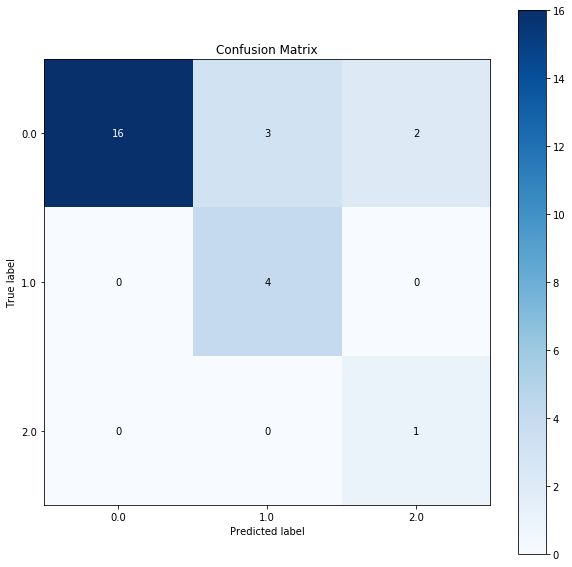

In [82]:
ax = skplt.metrics.plot_confusion_matrix(y_test_leo,predictions_general, figsize=(10,10))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.savefig('gm_leo_conf_mat.png')
plt.show()

Using the general model to test the performances by DiCaprio reveals that the model generally performs well, and over predicts the number of nominations and wins solely from the 0.0 category.

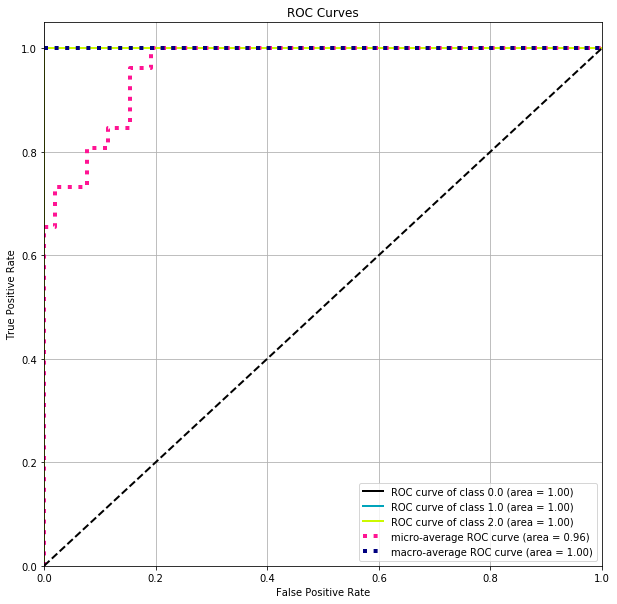

In [83]:
ax = skplt.metrics.plot_roc(y_test_leo, probability_general, classes_to_plot=[0,1,2], figsize=(10,10))
plt.grid()
plt.savefig('gm_leo_roc.png')
plt.show()

In [58]:
special_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=11, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
special_model.fit(X_train_non, y_train_non, eval_set=[(X_train_non,y_train_non),(X_test_leo,y_test_leo)], sample_weight=non_leo_wt, early_stopping_rounds=100)

[0]	validation_0-merror:0.27075	validation_1-merror:0.53846
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.24802	validation_1-merror:0.53846
[2]	validation_0-merror:0.20941	validation_1-merror:0.53846
[3]	validation_0-merror:0.20905	validation_1-merror:0.50000
[4]	validation_0-merror:0.21398	validation_1-merror:0.50000
[5]	validation_0-merror:0.20929	validation_1-merror:0.50000
[6]	validation_0-merror:0.20832	validation_1-merror:0.50000
[7]	validation_0-merror:0.20447	validation_1-merror:0.46154
[8]	validation_0-merror:0.20628	validation_1-merror:0.46154
[9]	validation_0-merror:0.20099	validation_1-merror:0.46154
[10]	validation_0-merror:0.20700	validation_1-merror:0.46154
[11]	validation_0-merror:0.20760	validation_1-merror:0.46154
[12]	validation_0-merror:0.21157	validation_1-merror:0.53846
[13]	validation_0-merror:0.20520	validation_1-merror:

[132]	validation_0-merror:0.16382	validation_1-merror:0.38461
[133]	validation_0-merror:0.16370	validation_1-merror:0.38461
[134]	validation_0-merror:0.16358	validation_1-merror:0.38461
[135]	validation_0-merror:0.16358	validation_1-merror:0.38461
[136]	validation_0-merror:0.16334	validation_1-merror:0.38461
[137]	validation_0-merror:0.16310	validation_1-merror:0.38461
[138]	validation_0-merror:0.16298	validation_1-merror:0.38461
[139]	validation_0-merror:0.16286	validation_1-merror:0.38461
[140]	validation_0-merror:0.16286	validation_1-merror:0.38461
[141]	validation_0-merror:0.16274	validation_1-merror:0.38461
[142]	validation_0-merror:0.16298	validation_1-merror:0.38461
[143]	validation_0-merror:0.16274	validation_1-merror:0.38461
[144]	validation_0-merror:0.16298	validation_1-merror:0.38461
[145]	validation_0-merror:0.16298	validation_1-merror:0.38461
[146]	validation_0-merror:0.16262	validation_1-merror:0.38461
[147]	validation_0-merror:0.16238	validation_1-merror:0.38461
[148]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

A specialized model is trained such that no information regarding DiCaprio is used in the model. This is done to gauge the scores associated to his performances based solely on the merit and performances of his hollywood peers.

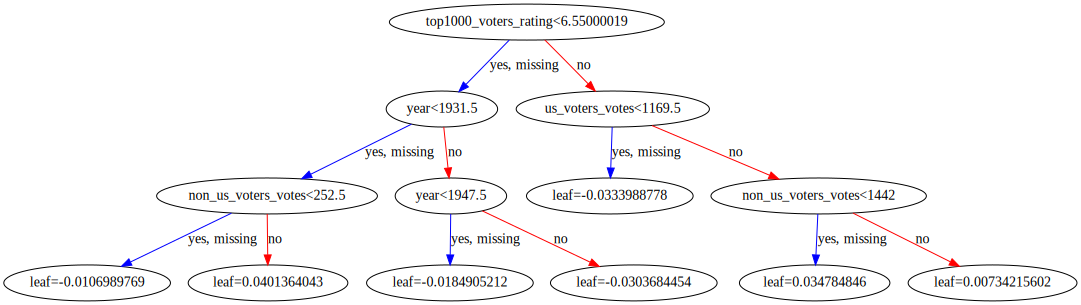

In [59]:
xgb.to_graphviz(special_model, num_trees=65)


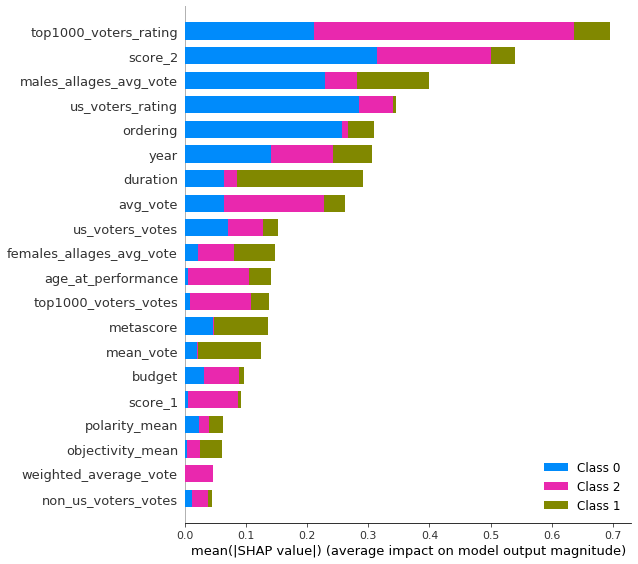

In [60]:
shap_explainer_special = shap.TreeExplainer(special_model)
shap_values_special = shap_explainer_special.shap_values(X_train_non)
shap.summary_plot(shap_values_special,X_train_non,show=False)
plt.savefig('sm_shap.png')
plt.show()

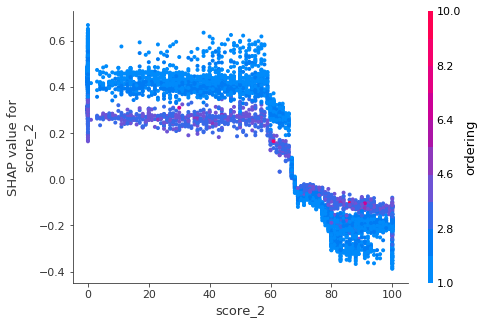

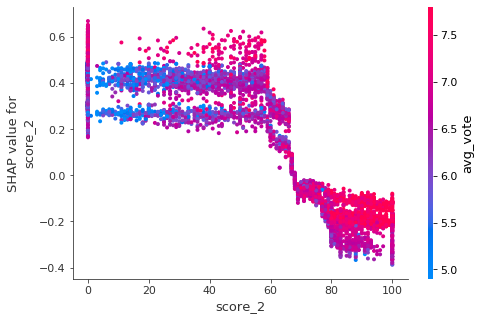

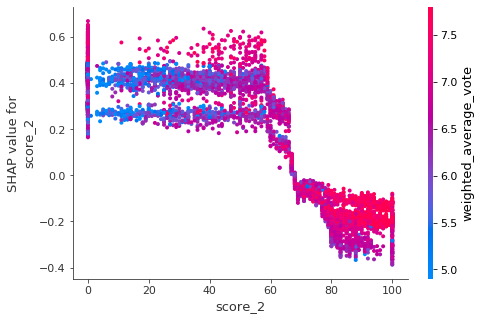

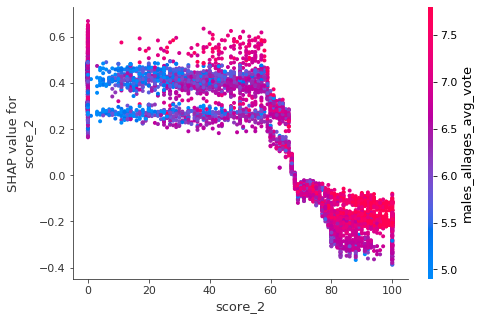

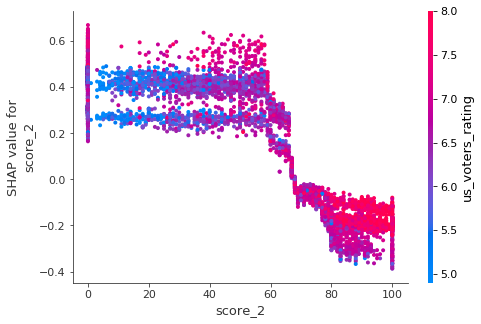

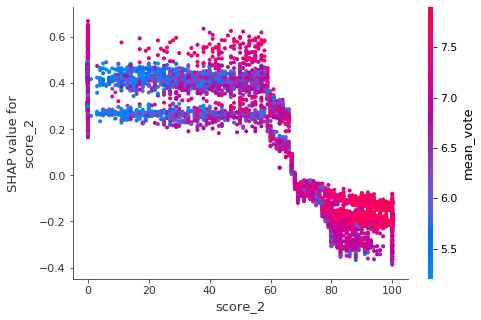

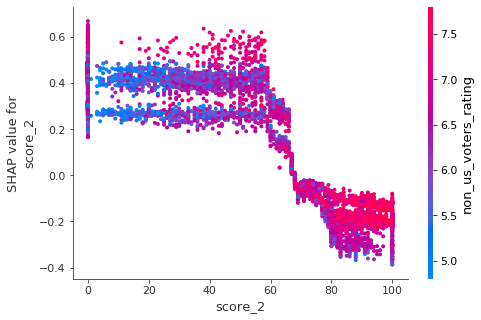

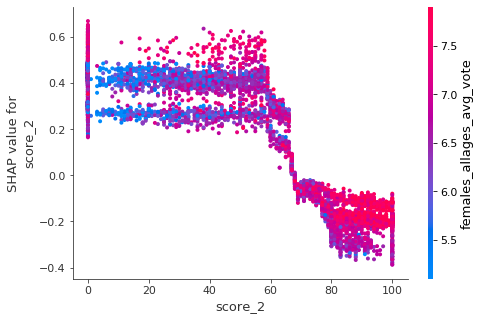

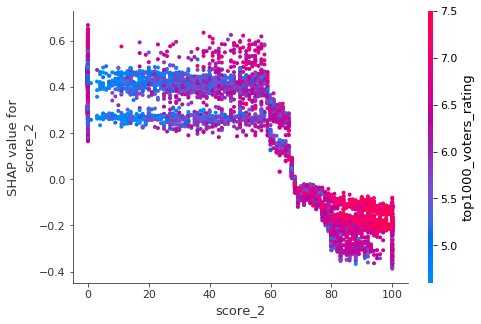

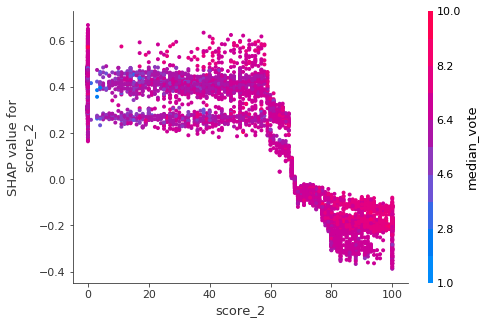

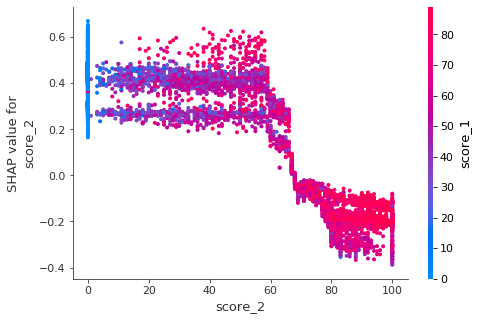

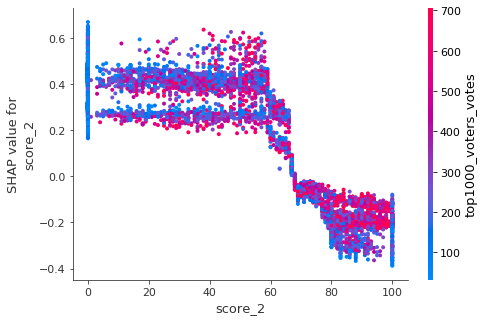

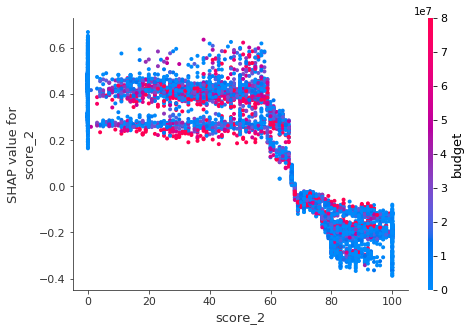

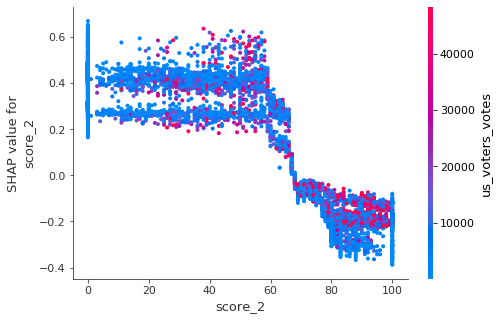

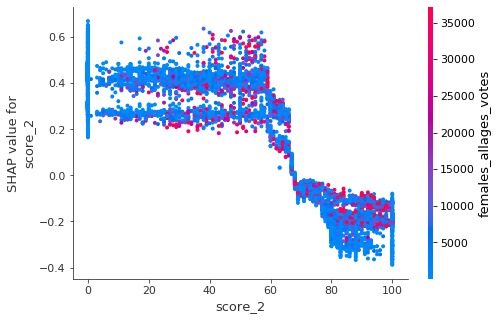

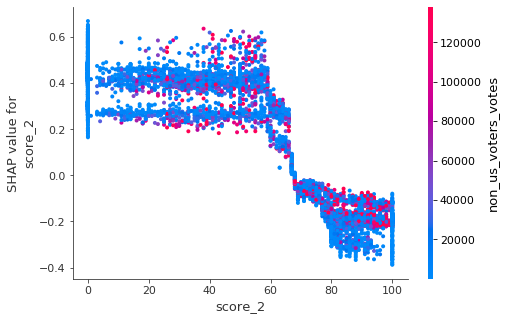

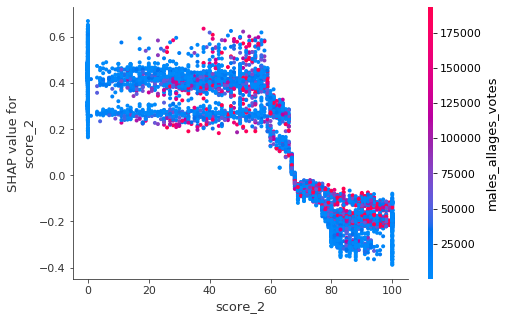

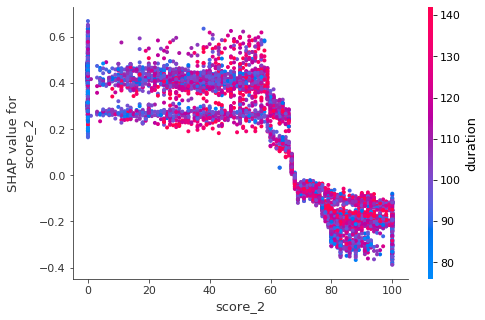

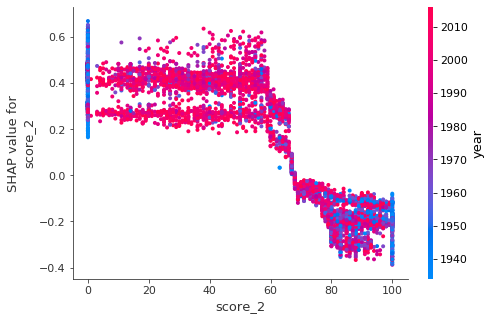

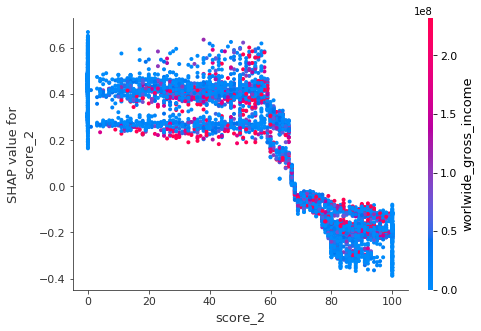

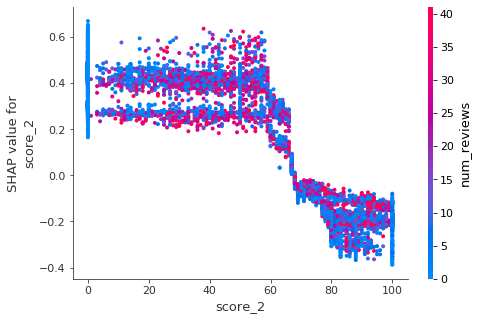

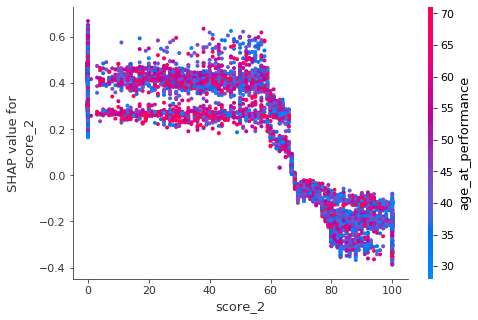

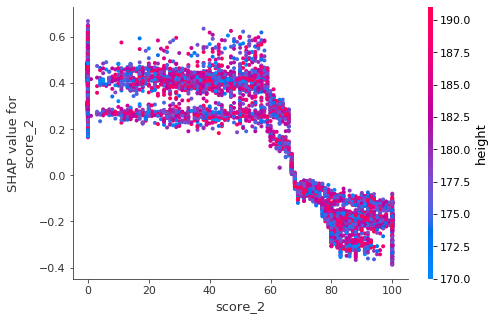

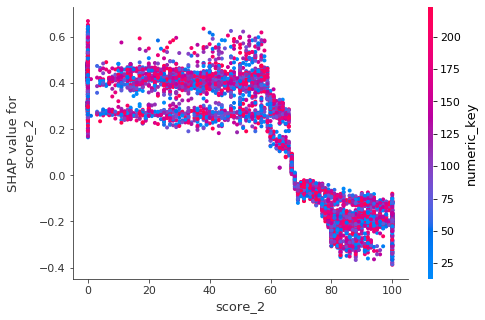

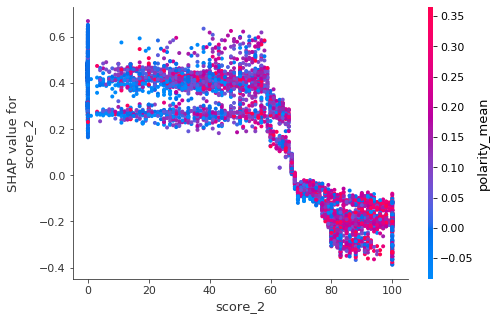

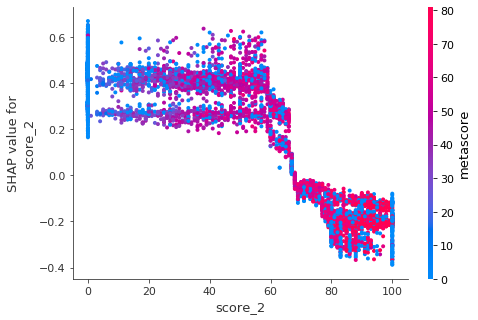

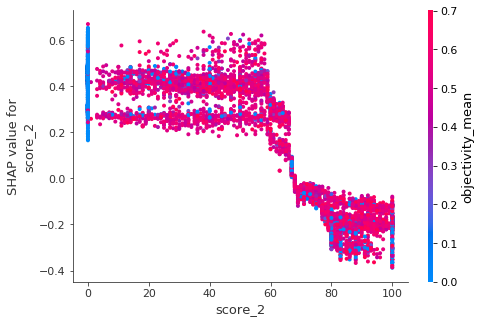

In [61]:
interactions_special = shap.approximate_interactions("score_2", shap_values_special[0],X_train_non)
for i in range(27):
    shap.dependence_plot("score_2",shap_values_special[0],X_train_non, interaction_index=interactions_special[i])

In [62]:
predictions_special = special_model.predict(X_test_leo)
probability_special = special_model.predict_proba(X_test_leo)
print('Prediction accuracy: {:.2%}'.format(metrics.balanced_accuracy_score(y_test_leo,predictions_special)))
print('AUC Score: {:.4}'.format(metrics.roc_auc_score(y_test_leo,probability_special, average='weighted',multi_class='ovo')))
leo_useful = leo_set[['role','title','award']]
leo_useful.reset_index(drop=True,inplace=True)
leo_pred_special = pd.DataFrame({'sm_predictions':predictions_special})
leo_pred_special.reset_index(drop=True, inplace=True)
special_comparison = pd.concat([leo_useful, leo_pred_special],axis=1)
special_comparison

Prediction accuracy: 77.38%
AUC Score: 0.8313


role                          title  award  \
0             howard hughes                    the aviator    1.0   
1              danny archer                  blood diamond    1.0   
2            jordan belfort        the wolf of wall street    1.0   
3                hugh glass                   the revenant    2.0   
4               rick dalton  once upon a time in hollywood    1.0   
5                jay gatsby               the great gatsby    0.0   
6             calvin candie               django unchained    0.0   
7            j edgar hoover                        j edgar    0.0   
8             teddy daniels                 shutter island    0.0   
9                  dom cobb                      inception    0.0   
10            frank wheeler             revolutionary road    0.0   
11             roger ferris                   body of lies    0.0   
12           billy costigan                   the departed    0.0   
13         amsterdam vallon              gangs of new york    0.0   
14         frank w abagnale            catch me if you can    0.0   
15                    derek                      dons plum    0.0   
16                  richard                      the beach    0.0   
17           brandon darrow                      celebrity    0.0   
18  king louis xiv/philippe       the man in the iron mask    0.0   
19              jack dawson                        titanic    0.0   
20                     hank                   marvins room    0.0   
21                  the kid         the quick and the dead    0.0   
22              jim carroll         the basketball diaries    0.0   
23           arthur rimbaud                  total eclipse    0.0   
24        tobias toby wolff                 this boys life    0.0   
25              arnie grape     whats eating gilbert grape    0.0   

    sm_predictions  
0              1.0  
1              1.0  
2              2.0  
3              2.0  
4              1.0  
5              0.0  
6              0.0  
7              0.0  
8              2.0  
9              2.0  
10             1.0  
11             0.0  
12             2.0  
13             1.0  
14             1.0  
15             0.0  
16             0.0  
17             0.0  
18             0.0  
19             1.0  
20             0.0  
21             0.0  
22             0.0  
23             0.0  
24             1.0  
25             1.0

This model has an overall lower ROC AUC score as well as a reduced accuracy, meaning that while the model is still fairly confident in it's predictions it is making more "false" predictions.

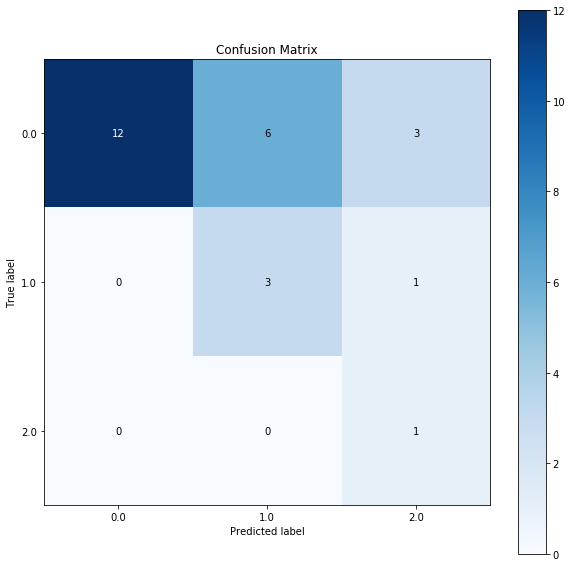

In [73]:
ax = skplt.metrics.plot_confusion_matrix(y_test_leo,predictions_special, figsize=(10,10))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.savefig('sm_leo_conf_mat.png')
plt.show()

From the CM it is clear that the model predicts far more nominations and wins than in the general case.

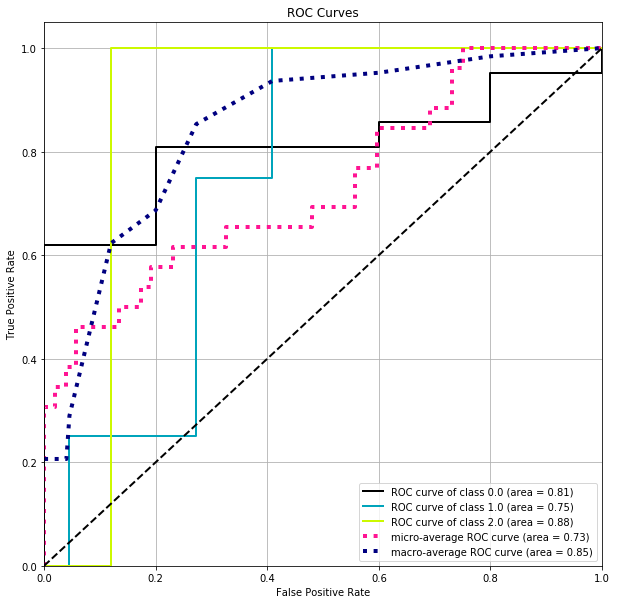

In [74]:
skplt.metrics.plot_roc(y_test_leo, probability_special, classes_to_plot=[0,1,2], figsize=(10,10))
plt.grid()
plt.savefig('sm_leo_roc.png')
plt.show()

In [75]:
overall_comp = pd.merge(leo_comparison, special_comparison, how='outer', on=['role','title','award'])

In [76]:
overall_comp['overlap'] = overall_comp['gm_predictions'] == overall_comp['sm_predictions']

In [96]:
overall_comp['avg_pred'] = np.select([overall_comp.overlap == True, overall_comp.overlap == False], [overall_comp.gm_predictions, overall_comp.award], default = overall_comp.award)

In [97]:
overall_comp

role                          title  award  \
0             howard hughes                    the aviator    1.0   
1              danny archer                  blood diamond    1.0   
2            jordan belfort        the wolf of wall street    1.0   
3                hugh glass                   the revenant    2.0   
4               rick dalton  once upon a time in hollywood    1.0   
5                jay gatsby               the great gatsby    0.0   
6             calvin candie               django unchained    0.0   
7            j edgar hoover                        j edgar    0.0   
8             teddy daniels                 shutter island    0.0   
9                  dom cobb                      inception    0.0   
10            frank wheeler             revolutionary road    0.0   
11             roger ferris                   body of lies    0.0   
12           billy costigan                   the departed    0.0   
13         amsterdam vallon              gangs of new york    0.0   
14         frank w abagnale            catch me if you can    0.0   
15                    derek                      dons plum    0.0   
16                  richard                      the beach    0.0   
17           brandon darrow                      celebrity    0.0   
18  king louis xiv/philippe       the man in the iron mask    0.0   
19              jack dawson                        titanic    0.0   
20                     hank                   marvins room    0.0   
21                  the kid         the quick and the dead    0.0   
22              jim carroll         the basketball diaries    0.0   
23           arthur rimbaud                  total eclipse    0.0   
24        tobias toby wolff                 this boys life    0.0   
25              arnie grape     whats eating gilbert grape    0.0   

    gm_predictions  sm_predictions  overlap  avg_pred  
0              1.0             1.0     True       1.0  
1              1.0             1.0     True       1.0  
2              1.0             2.0    False       1.0  
3              2.0             2.0     True       2.0  
4              1.0             1.0     True       1.0  
5              0.0             0.0     True       0.0  
6              0.0             0.0     True       0.0  
7              0.0             0.0     True       0.0  
8              0.0             2.0    False       0.0  
9              2.0             2.0     True       2.0  
10             1.0             1.0     True       1.0  
11             0.0             0.0     True       0.0  
12             2.0             2.0     True       2.0  
13             1.0             1.0     True       1.0  
14             1.0             1.0     True       1.0  
15             0.0             0.0     True       0.0  
16             0.0             0.0     True       0.0  
17             0.0             0.0     True       0.0  
18             0.0             0.0     True       0.0  
19             0.0             1.0    False       0.0  
20             0.0             0.0     True       0.0  
21             0.0             0.0     True       0.0  
22             0.0             0.0     True       0.0  
23             0.0             0.0     True       0.0  
24             0.0             1.0    False       0.0  
25             0.0             1.0    False       0.0

In [99]:
pickle.dump(general_model, open("finer_predictions_2.dat","wb")) #generalized_model pickled for later deployment

The general model is pickled to be used in making predictions for all actors that have won or received a nomination for best actor.